# Example of hyperfine quadrupole spectrum of $\text{S}_2\text{Cl}_2$ molecule

Calculate rotational hyperfine energies and spectrum of the asymmetric isotopologue $\text{S}_2\text{Cl}_2$, including the nuclear quadrupole interaction arising from the nuclear quadrupole couplings of the two chlorine nuclei.
The results of spectral simulations are compared with transitions observed by [Kanamori] and calculations by [Wichmann].

Each chlorine nucleus has a nuclear spin of $I = \tfrac{3}{2}$, with nuclear quadrupole moments of $Q(^{35}\text{Cl}) = -81.65$ mb and $Q(^{37}\text{Cl}) = -64.35$ mb  [Pyykkö], and magnetic dipoles of $\mu(^{35}\text{Cl}) = 0.8218743$ and $\mu(^{37}\text{Cl})=0.6841236$ (in units of nuclear magneton) [Stone].

The molecular geometry, dipole moment, and electric field gradient tensors (EFG) used in this simulation are defined in the module [s2cl2_cc.py](s2cl2_cc.py) (or [s2cl2_dft.py](s2cl2_dft.py)).
The effective-Hamiltonian constants for the pure rotational solutions are taken from Table 3 of [Wichmann], originally derived in [Dehghani].

References:
- [Wichmann] Wichmann, Seyfang, Quack, Mol. Phys. 119 (2021) e1959073, DOI: https://doi.org/10.1080/00268976.2021.1959073
- [Kanamori] Kanamori, Dehghani, Mizoguchi, Yasuki Endo, Phys. Rev. Lett. 119 (2017) 173401, DOI: https://doi.org/10.1103/PhysRevLett.119.173401
- [Dehghani] Dehghani, Ota, Mizoguchi, Kanamori, J. Phys. Chem. A 117 (2013) 10041, DOI: https://doi.org/10.1021/jp400632g
- [Pyykkö] Pyykkö, Year-2008 Nuclear Quadrupole Moments, Mol. Phys. 106 (2008) 1965, DOI: http://dx.doi.org/10.1080/00268970802018367

In [1]:
import sys

sys.path.append("../utils")

import matplotlib.pyplot as plt
import numpy as np
import s2cl2_cc as s2cl2
from matplotlib.ticker import FuncFormatter, MaxNLocator
from plot_dens import plot_mc_dens, plot_mc_spin_dens
from richmol import (
    CartTensor,
    HyperCartTensor,
    HyperStates,
    QuadMom,
    RotStates,
    Spin1Tensor,
)
from richmol.asymtop import com, inertia_tensor, rotational_constants, write_xyz
from richmol.rotsym import R0, RalphaPi, RzBeta
from scipy import constants
from scipy.sparse import csr_array

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

Rotate *ab initio* calculated geometry, dipole moment, and EFG tensors to the principal axes system (PAS).

Store the rotated geometry in an XYZ-file and plot the molecule (e.g., using Avogadro).

In [22]:
atom_masses = s2cl2.atom_masses
atom_labels = s2cl2.atom_labels

(A, B, C), v = rotational_constants(atom_masses, s2cl2.atom_xyz)
kappa = (2 * B - A - C) / (A - C)
print("A, B, C (cm^-1):", A, B, C)
print("A, B, C (MHz):", *(elem * constants.c * 1e-4 for elem in (A, B, C)))
print("kappa:", kappa)
if kappa < 0:
    print("prolate top")
    perm_mat = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
else:
    print("oblate top")
    perm_mat = np.eye(3)

pas = perm_mat @ v.T

atom_xyz = (s2cl2.atom_xyz - com(atom_masses, s2cl2.atom_xyz)) @ pas.T
write_xyz("s2cl2_35_35_pas_coords.xyz", atom_labels, atom_xyz)

# check that inertia tensor is diagonal in PAS
imom = inertia_tensor(atom_masses, atom_xyz)
print(
    "Inertia tensor diagonal?:",
    np.allclose(imom, np.diag(np.diagonal(imom)), atol=1e-12),
)

dip_mol = pas @ np.array(s2cl2.dip_mol)
efg_mol_cl1 = pas @ np.array(s2cl2.efg_mol_cl1) @ pas.T
efg_mol_cl2 = pas @ np.array(s2cl2.efg_mol_cl2) @ pas.T

print("Dipole moment in PAS:\n", dip_mol)
print("EFG on Cl1 in PAS:\n", efg_mol_cl1)
print("EFG on Cl2 in PAS:\n", efg_mol_cl2)

print("EFG(Cl1) - EFG(Cl2) (diag):\n", np.diag(efg_mol_cl1 - efg_mol_cl2))

A, B, C (cm^-1): 0.1775541627444763 0.04578597674771517 0.04046941072483893
A, B, C (MHz): 5322.939887729858 1372.6290511128375 1213.2424115011024
kappa: -0.9224338820394169
prolate top
Inertia tensor diagonal?: True
Dipole moment in PAS:
 [0.36514176 0.         0.        ]
EFG on Cl1 in PAS:
 [[ 0.8160628   1.5436752   2.44973188]
 [ 1.5436752  -1.16191946  1.12708828]
 [ 2.44973188  1.12708828  0.34585666]]
EFG on Cl2 in PAS:
 [[ 0.8160628  -1.5436752  -2.44973188]
 [-1.5436752  -1.16191946  1.12708828]
 [-2.44973188  1.12708828  0.34585666]]
EFG(Cl1) - EFG(Cl2) (diag):
 [0. 0. 0.]


In [3]:
# print(" & ".join("%7.3f"% elem for elem in efg_mol_cl1[np.triu_indices(3)]))
# print(" & ".join("%7.3f"% elem for elem in efg_mol_cl2[np.triu_indices(3)]))

As shown on the molecular plot below, the orientation of the $x,y,z$ axes (or $b,c,a$ in the $I^r$ convention for prolate top) in the PAS frame is such that the $x$-axis aligns with the $C_2$ symmetry axis of the molecule.

The $C_2$ equivalent rotation is thus $R_x^{\pi}\equiv R_{0}^{\pi}$ (rotation about $x$ by $\pi$), which we will provide to the rotational solver in order to identify symmetries of rotational states within the $C_2$ symmetry group.

<img src="s2cl2_35_35_pas_coords.png" alt="" width="300"/>

Compute the rotational states using effective-Hamiltonian approach, and rotational matrix elements of interaction tensors.

To represent the symmetry operations of the $C_2$ group, we use two equivalent rotations:
- $R_0$ (identity rotation), representing the $E$ operation,
- $R_{0}^\pi$, representing the $C_2$ rotation about the symmetry axis.

The corresponding character vectors for the irreps are:
- Symmetry A: [1, 1],
- Symmetry B: [1, -1].

In [4]:
# Rotational constants from [Wichmann] ([Dehghani])
inp = (
    "A/MHz",      5533.8964,
    "B/MHz",      1393.8436,
    "C/MHz",      1232.6728,
    "DeltaJ/kHz",    0.556,
    "DeltaJK/kHz",  -5.115,
    "DeltaK/kHz",   24.70,
    "d1/kHz",        0.144,
)

jmax = 20
states = RotStates.watson(
    jmax,
    inp,
    print_enr=True,
    rotations=[R0(), RalphaPi(0)],
    irreps={"A": [1, 1], "B": [1, -1]},
)

dip_lab = CartTensor(states, dip_mol)
efg_lab_cl1 = CartTensor(states, efg_mol_cl1)
efg_lab_cl2 = CartTensor(states, efg_mol_cl2)


Compute rotational solutions using Watson's effective Hamiltonian approach
Input rotational constants (MHz):
          A  5533.896400000000 
          B  1393.843600000000 
          C  1232.672800000000 
     DeltaJ     0.000556000000 
    DeltaJK    -0.005115000000 
     DeltaK     0.024700000000 
         d1     0.000144000000 
Watson reduction form: S
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 0 and symmetry B ...
number of functions: 0
solve for J = 0 and symmetry A ...
number of functions: 1
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 1 and symmetry B ...
number of functions: 2
s

Compare rotational energies with previously computed values, given in Table 4 of [Wichmann].

In [5]:
# Rotational energies from Table 4 of [Wichmann]
Wichmann_enr = [
    ("A", 0.00),
    ("B", 2626.51),
    ("A", 6766.55),
    ("B", 6927.72),
    ("A", 7874.91),
    ("B", 11858.42),
    ("A", 12341.92),
    ("B", 15735.97),
    ("A", 19493.36),
    ("B", 20460.26),
    ("B", 24761.81),
    ("A", 24766.42),
    ("A", 26195.98),
    ("B", 29668.03),
    ("A", 31279.05),
    ("A", 32641.42),
    ("B", 32664.47),
    ("B", 39237.15),
    ("A", 42378.20),
    ("B", 43143.92),
    ("A", 43212.88),
    ("B", 44793.19),
    ("A", 53746.16),
    ("B", 53746.24),
    ("A", 54838.34),
    ("A", 56266.17),
    ("B", 56426.26),
    ("B", 57618.84),
    ("A", 60996.00),
    ("B", 64261.43),
]

enr = sorted(
    [
        (sym, float(e))
        for j in states.enr.keys()
        for sym in states.enr[j].keys()
        for e in states.enr[j][sym]
    ],
    key=lambda arg: arg[-1],
)

for (sym, e), (ref_sym, ref_e) in zip(enr, Wichmann_enr):
    print(sym, ref_sym, e, ref_e, round(e - ref_e, 2))

A A 0.0 0.0 0.0
B B 2626.514176 2626.51 0.0
A A 6766.552505999999 6766.55 0.0
B B 6927.723305999999 6927.72 0.0
A A 7874.914476559307 7874.91 0.0
B B 11858.417173999995 11858.42 -0.0
A A 12341.929573999994 12341.92 0.01
B B 15735.97012545707 15735.97 0.0
A A 19493.336723578534 19493.36 -0.02
B B 20460.27889671142 20460.26 0.02
B B 24761.809543999996 24761.81 -0.0
A A 24766.424251440687 24766.42 0.0
A A 26195.97399489998 26195.98 -0.01
B B 29667.97277227708 29668.03 -0.06
A A 31279.102659226908 31279.05 0.05
A A 32641.421455999996 32641.42 0.0
B B 32664.469666542922 32664.47 -0.0
B B 39237.111979703 39237.15 -0.04
A A 42378.06161611046 42378.2 -0.14
B B 43143.91818124268 43143.92 -0.0
A A 43212.88455895184 43212.88 0.0
B B 44793.31326625207 44793.19 0.12
A A 53746.157948421445 53746.16 -0.0
B B 53746.24057528856 53746.24 0.0
A A 54838.24886270883 54838.34 -0.09
A A 56266.17198446328 56266.17 0.0
B B 56426.29456200181 56426.26 0.03
B B 57618.567148233444 57618.84 -0.27
A A 60996.23368107

Define symmetry rules for the coupling of rotational and nuclear spin states.

In [6]:
# Define symmetry coupling rules between rotational and nuclear spin states.
# Each Cl nucleus has spin I = 3/2, so the total nuclear spin (I_total) can be 0, 1, 2, or 3.
# The corresponding nuclear spin symmetries in C2 group are B, A, B, and A, respectively.
#
# Due to the Pauli exclusion principle, the total spin-rotational wavefunction must be
# antisymmetric (B symmetry) under exchange of the two identical fermionic Cl nuclei.
#
# As a result:
# - Nuclear spin states with I_total = 0 and 2 (B symmetry) must couple to rotational states with A symmetry.
# - Nuclear spin states with I_total = 1 and 3 (A symmetry) must couple to rotational states with B symmetry.
#
# The function `symmetry_rules` below encodes these selection rules.


def symmetry_rules(
    j_list: list[int],
    j_sym_list: dict[int, list[str]],
    spin_list: list[tuple[float]],
) -> dict[str, list[tuple[int, tuple[float], str, str]]]:
    c2_prod = {
        ("A", "B"): "B",
        ("B", "A"): "B",
        # ("A", "A"): "A",  # forbidden by Pauli principle
        # ("B", "B"): "A",  # forbidden by Pauli principle
    }
    j_spin_list = {"B": []}
    for j, spin in zip(j_list, spin_list):
        tot_spin = spin[-1]  # can be 0, 1, 2, 3
        for j_sym in j_sym_list[j]:
            if tot_spin in (1, 3):
                spin_sym = "A"
            elif tot_spin in (0, 2):
                spin_sym = "B"
            else:
                raise ValueError(
                    f"Symmetry of state with total spin = {tot_spin} is not defined"
                )
            try:
                f_sym = c2_prod[(j_sym, spin_sym)]
            except KeyError:
                continue
            j_spin_list[f_sym].append((j, spin, j_sym, spin_sym))
    return j_spin_list

Compute hyperfine states using effective-Hamiltonian rotational states, ab initio calculated EFG tensors, and quadrupole moments from [Pyykkö].

In [14]:
# Compute rotational matrix elements of laboratory-frame tensors

# Quadrupole moment of {35}^Cl (in mb) from [Pyykkö]
quad_cl35 = QuadMom(spin=3 / 2, Q=-81.65)

# Compute hyperfine states and matrix elements of laboratory-frame tensors

hyper_states = HyperStates(
    0,
    jmax - 3,
    states,
    spin_op=[quad_cl35, quad_cl35],
    efg_op=[efg_lab_cl1, efg_lab_cl2],
    symmetry_rules=symmetry_rules,
)

# Compute matrix elements of lab-frame dipole moment and nuclear spins in hyperfine basis
hyper_dip_lab = HyperCartTensor(hyper_states, dip_lab)
spin_tens1 = Spin1Tensor(0, hyper_states)
spin_tens2 = Spin1Tensor(1, hyper_states)


Compute hyperfine states
List of F quanta: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0)]
F   tot.sym.   J   (I_1, I_12, ... I_1N)     rovib.sym.   spin.sym.  rovib.dim 
----------------------------------------------------------------------------
0.0 B          0   (1.5, 0)                  A            B          1         
0.0 B          1   (1.5, 1)                  B            A          2         
0.0 B          2   (1.5, 2)                  A            B          3         
0.0 B          3   (1.5, 3)                  B            A          4         
1.0 B          1   (1.5, 0)                  A            B          1         
1.0 B          1   (1.5, 1)                  B            A          2         
1.0 

Print the hyperfine states and assignments, as well as the weights of ortho and para contributions.

The results are similar to those in Table 6 of [Wichmann], although here we employ ab initio calculated EFG tensors instead of experimentally determined quadrupole coupling constants.

In [31]:
# zero-point energy
zpe = np.min(
    [
        np.min(enr_sym)
        for enr_f in hyper_states.enr.values()
        for enr_sym in enr_f.values()
    ]
)

enr = []
for f in hyper_states.enr.keys():
    for sym in hyper_states.enr[f].keys():

        # extract (J, k, tau, I, F) quanta
        quanta = hyper_states.quanta_dict_k[f][sym]
        j_k_tau_i_f = [
            (*elem[6:9], elem[3], float(elem[0]), sym)
            for elem in hyper_states.quanta_dict_k[f][sym]
        ]

        # p(I) = \sum_i |c_i|^2 for spin I=0,1,2,3
        op_quanta = hyper_states.quanta_dict_op[f][sym]

        # compute p(para) = \sum_i |c_i|^2 for spin in (0, 2)
        #     and p(ortho) = \sum_i |c_i|^2 for spin in (1, 3)
        para_coef = [sum(c for (q, c) in qua if int(q) in (0, 2)) for qua in op_quanta]
        ortho_coef = [sum(c for (q, c) in qua if int(q) in (1, 3)) for qua in op_quanta]

        # assemble (J, k, tau, I, F, energy-zpe, p(para), p(ortho))
        enr += [
            (*q, float(e - zpe), pc, oc, ind)
            for ind, (q, e, pc, oc) in enumerate(
                zip(j_k_tau_i_f, hyper_states.enr[f][sym], para_coef, ortho_coef)
            )
        ]


# sort wrt energy
enr = sorted(enr, key=lambda elem: elem[6])


print(
    f"{'J':>2} {'k':>2} {'tau':>1} {'I':>1} {'F':>2} {'Energy (MHz)':>16} {'p_para':>10} {'p_ortho':>10}"
)
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    if f > 10:
        continue
    print(
        f"{j:2d}",
        f"{k:2d}",
        f"{tau:2d}",
        f"{int(spin):2d}",
        f"{int(f):2d}",
        f"{e:16.4f}",
        f"{p_c:10.6f}",
        f"{o_c:10.6f}",
    )

 J  k tau I  F     Energy (MHz)     p_para    p_ortho
 0  0  0  2  2           0.0000   0.999995   0.000005
 0  0  0  0  0           0.0441   1.000000   0.000000
 1  0  1  1  0        2623.8761   0.000002   0.999998
 1  0  1  3  3        2624.5290   0.000007   0.999993
 1  0  1  1  2        2625.4169   0.000011   0.999989
 1  0  1  3  4        2627.2073   0.000001   0.999999
 1  0  1  1  1        2627.8300   0.000012   0.999988
 1  0  1  3  2        2628.9298   0.000008   0.999992
 1  1  1  2  1        6761.3846   0.998438   0.001562
 1  1  1  2  2        6765.8939   0.995567   0.004433
 1  1  1  2  3        6766.3845   0.998755   0.001245
 1  1  1  0  1        6771.2736   0.998336   0.001664
 1  1  0  3  2        6919.6059   0.002128   0.997872
 1  1  0  1  1        6923.7854   0.003251   0.996749
 1  1  0  3  4        6925.4583   0.000084   0.999916
 1  1  0  1  2        6931.8521   0.002656   0.997344
 1  1  0  3  3        6934.4335   0.001492   0.998508
 1  1  0  1  0        6936.2

For comparison, here is an extract of Table 6 from [Wichmann].

<img src="../etc/data/s2cl2/Wichmann_MP119_2021_Table6.png" alt="Extract from Table 6 in Wichmann, et al. Mol. Phys. 119 (2021) e1959073" width="500"/>

Plot *para* (*ortho*) weights for states as function of their energy.

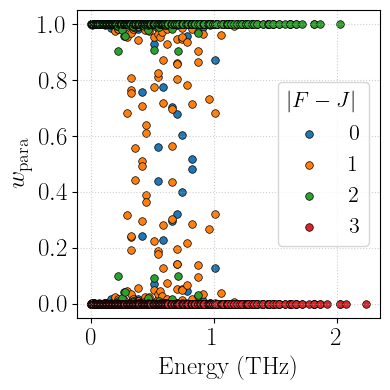

In [23]:
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    try:
        e_j[abs(f - j)].append((e, p_c))
    except KeyError:
        e_j[abs(f - j)] = [(e, p_c)]

fig = plt.figure(figsize=(4, 4), dpi=100)

colors = {0.0: "tab:blue", 1.0: "tab:orange", 2.0: "tab:green", 3.0: "tab:red"}

for key in sorted(list(e_j.keys())):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e / 1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker="o",
        label=f"{int(key)}",
        s=30,
        facecolors=colors[key],
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
plt.legend(fontsize=16, title_fontsize=16, loc="center right", title="$|F-J|$")
plt.tight_layout()
plt.savefig(f"s2cl2_35_35_op_diagram.pdf", format="pdf", bbox_inches="tight")

Same plot as above, color-coded wrt $k$.

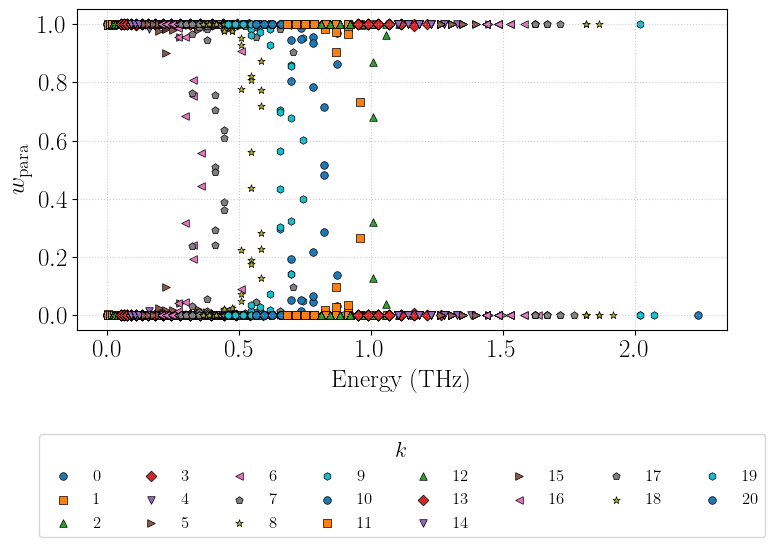

In [17]:
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    try:
        e_j[k].append((e, p_c))
    except KeyError:
        e_j[k] = [(e, p_c)]

fig = plt.figure(figsize=(8, 6), dpi=100)

markers = ["o", "s", "^", "D", "v", ">", "<", "p", "*", "h"]

for i, key in enumerate(sorted(list(e_j.keys()))):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e / 1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker=markers[i % len(markers)],
        # label=f"{int(key)}",
        label=f"{key}",
        s=30,
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
plt.legend(
    fontsize=12,
    title_fontsize=16,
    ncol=8,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    title="$k$",
)
plt.tight_layout()

Zoom into specific $k$, color-coded wrt $J$

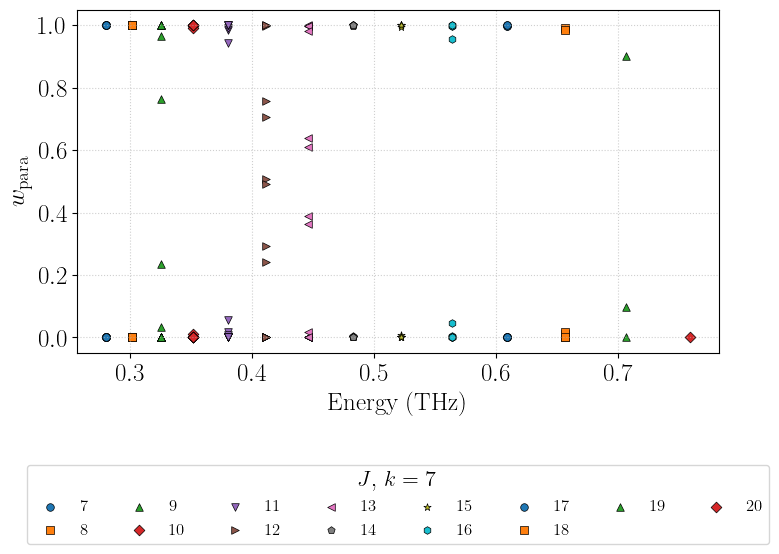

In [18]:
e_j = {}
k0 = 7
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    if k!=k0: continue
    try:
        e_j[j].append((e, p_c))
    except KeyError:
        e_j[j] = [(e, p_c)]

fig = plt.figure(figsize=(8, 6), dpi=100)

markers = ["o", "s", "^", "D", "v", ">", "<", "p", "*", "h"]

for i, key in enumerate(sorted(list(e_j.keys()))):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e / 1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker=markers[i % len(markers)],
        label=f"{key}",
        s=30,
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
plt.legend(
    fontsize=12,
    title_fontsize=16,
    ncol=8,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    title=f"$J$, $k={k0}$",
)
plt.tight_layout()


Compute expectation values of nuclear spin operators for selected states.

In [19]:
# Returns matrix elements of a selected Cartesian component of nuclear spin operators
def spin_me(cart_comp: str, f1, sym1, m1, ind1, f2, sym2, m2, ind2):
    m_ind1 = np.where(np.arange(-f1, f1 + 1) == m1)[0][0]
    m_ind2 = np.where(np.arange(-f2, f2 + 1) == m2)[0][0]
    try:
        mmat1 = spin_tens1.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat1 = spin_tens1.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        mmat2 = spin_tens2.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat2 = spin_tens2.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        return kmat1 * mmat1, kmat2 * mmat2
    except KeyError:
        return 0, 0


# Returns matrix elements of a selected Cartesian component of electric dipole moment
def dip_me(cart_comp: str, f1, sym1, m1, ind1, f2, sym2, m2, ind2):
    m_ind1 = np.where(np.arange(-f1, f1 + 1) == m1)[0][0]
    m_ind2 = np.where(np.arange(-f2, f2 + 1) == m2)[0][0]
    try:
        mmat = hyper_dip_lab.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat = hyper_dip_lab.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        return kmat * mmat
    except KeyError:
        return 0

In [20]:
print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'I':>4} {'F':>4} {'ind':>6} {'E (MHz)':>14} {'|F - J|':>7} {'w_para':>7} {'w_ortho':>7} "
    f"{'<I_z1>':>10} {'<I_z2>':>10}"
)

cart_comp = "z"

for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    m = f
    if k == 7 and j in (12,):  # select k and J

        spin_me1, spin_me2 = spin_me(cart_comp, f, sym, m, ind, f, sym, m, ind)
        eTHz = round(e / 1e6, 6)
        eMHz = round(e, 4)

        print(
            f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eMHz:14.4f} {abs(j - f):7.1f} {p_c:7.1f} {o_c:7.1f} "
            f"{spin_me1.real:10.3f} {spin_me2.real:10.3f}"
        )

        # print(
        #     f"{j:3} & {k:3} & {tau:4} & {round(spin):4} & {round(f):4} & {eMHz:14.4f} & {p_c:6.2f} & {o_c:6.2f} & {spin_me1.real:10.3f} & {spin_me2.real:10.3f} \\\\"
        # )


  j   k  tau    I    F    ind        E (MHz) |F - J|  w_para w_ortho     <I_z1>     <I_z2>
 12   7    0  3.0  9.0    123    411775.0324     3.0     0.0     1.0     -1.350     -1.350
 12   7    0  1.0 12.0    109    411775.0468     0.0     0.2     0.8      0.056      0.056
 12   7    1  2.0 12.0    110    411775.0469     0.0     0.8     0.2      0.059      0.059
 12   7    0  3.0 15.0     65    411775.0599     3.0     0.0     1.0      1.500      1.500
 12   7    0  3.0 10.0    124    411775.1206     2.0     0.0     1.0     -0.773     -0.773
 12   7    1  2.0 11.0    114    411775.1407     1.0     0.5     0.5     -0.363     -0.363
 12   7    1  2.0 11.0    115    411775.1437     1.0     0.5     0.5     -0.361     -0.361
 12   7    1  2.0 14.0     85    411775.1464     2.0     1.0     0.0      1.000      1.000
 12   7    1  2.0 13.0     95    411775.1469     1.0     0.7     0.3      0.568      0.568
 12   7    1  2.0 10.0    125    411775.1497     2.0     1.0     0.0     -0.909     -0.909

Plot nuclear spin densities for selected states.
Since these calculations are time-consuming, you may skip this cell if density plots are not required.

In [21]:
print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'I':>4} {'F':>4} {'ind':>6} {'E (MHz)':>14} {'|F - J|':>7} {'w_para':>7} {'w_ortho':>7} "
    f"{'<I_z1>':>10} {'<I_z2>':>10}"
)

cart_comp = "z"

for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    m = f
    if k == 7 and j in (12,):  # select k and J
        eTHz = round(e / 1e6, 6)

        spin_me1, spin_me2 = spin_me(cart_comp, f, sym, m, ind, f, sym, m, ind)

        print(
            f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eMHz:14.4f} {abs(j - f):7.1f} {p_c:7.1f} {o_c:7.1f} "
            f"{spin_me1.real:10.3f} {spin_me2.real:10.3f}"
        )

        # plot_mc_dens(
        #     hyper_states,
        #     states,
        #     f,
        #     sym,
        #     m,
        #     ind,
        #     atom_xyz[2:],  # Cl1 and Cl2
        #     atom_labels=atom_labels[2:],  # Cl1 and Cl2
        #     npoints=200000,
        #     filename=f"dens_plots/s2cl2_35_37_dens_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
        #     coef_thresh=1e-4,
        # )

        plot_mc_spin_dens(
            hyper_states,
            states,
            f,
            sym,
            m,
            ind,
            atom_xyz[2:],  # Cl1 and Cl2
            atom_labels=atom_labels[2:],  # Cl1 and Cl2
            cart_comp=cart_comp,
            npoints=200000,
            filename=f"dens_plots/s2cl2_35_35_spindens_{cart_comp}_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
            coef_thresh=1e-4,
        )

  j   k  tau    I    F    ind        E (MHz) |F - J|  w_para w_ortho     <I_z1>     <I_z2>
 12   7    0  3.0  9.0    123    411775.2510     3.0     0.0     1.0     -1.350     -1.350
 12   7    0  1.0 12.0    109    411775.2510     0.0     0.2     0.8      0.056      0.056
 12   7    1  2.0 12.0    110    411775.2510     0.0     0.8     0.2      0.059      0.059
 12   7    0  3.0 15.0     65    411775.2510     3.0     0.0     1.0      1.500      1.500
 12   7    0  3.0 10.0    124    411775.2510     2.0     0.0     1.0     -0.773     -0.773
 12   7    1  2.0 11.0    114    411775.2510     1.0     0.5     0.5     -0.363     -0.363
 12   7    1  2.0 11.0    115    411775.2510     1.0     0.5     0.5     -0.361     -0.361
 12   7    1  2.0 14.0     85    411775.2510     2.0     1.0     0.0      1.000      1.000
 12   7    1  2.0 13.0     95    411775.2510     1.0     0.7     0.3      0.568      0.568
 12   7    1  2.0 10.0    125    411775.2510     2.0     1.0     0.0     -0.909     -0.909

### Compute spectrum

Define function `dipole_linestr` for computing transition linestrengths
$$
S(F',i\leftarrow F,j) = \sum_{m_F',m_F}\sum_{A=X,Y,Z}\left|\langle F',m_F',i|\mu_A|F,m_F,j\rangle\right|^2,
$$
where $i,j$ are indices of hyperfine states with total spin-rotational angular momentum $F'$ and $F$, respectively.

In [24]:
def dipole_linestr(
    dip: CartTensor,
) -> dict[tuple[float, float], dict[tuple[str, str], csr_array]]:
    assert (
        dip.rank == 1
    ), f"Unexpected rank of the input 'dip' tensor = {dip.rank} (must be equal to 1)"

    ls = {}
    for j_pair in list(set(dip.mmat.keys()) & set(dip.kmat.keys())):
        mmat = dip.mmat[j_pair]
        kmat = dip.kmat[j_pair]

        m_prefac = np.sum(
            [np.sum(np.abs(mmat_cart[1]) ** 2) for mmat_cart in mmat.values()]
        )  # must be equal to (2*j1+1)*(2*j2+1), where j1,j2=j_pair

        ls_sym = {}
        for sym_pair, kmat_s in kmat.items():
            ls_sym[sym_pair] = m_prefac * np.abs(kmat_s[1]) ** 2

        if ls_sym:
            ls[j_pair] = ls_sym

    return ls

Compute linestrenghts for all states in `hyper_states`.

In [25]:
ls = dipole_linestr(hyper_dip_lab)

Estimate partition function.

In [26]:
temp = 10.0  # Kelvin

if hyper_states.enr_units == "invcm":
    boltz_beta = constants.h * constants.c / (constants.k * temp) * 100
elif hyper_states.enr_units == "mhz":
    boltz_beta = constants.h / (constants.k * temp) * 1e6
else:
    raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")

enr, m_degen = np.array(
    [
        (e, 2 * f + 1)
        for f in hyper_states.f_list
        for sym in hyper_states.f_sym_list[f]
        for e in hyper_states.enr[f][sym]
    ]
).T
zpe = np.min(enr)

part_func = np.sum(m_degen * np.exp(-(enr - zpe) * boltz_beta))
print(f"partition function for (T = {temp} K):", part_func)

partition function for (T = 10.0 K): 11619.936751693444


Define function `stick_spectrum` for computing absorption intensities for selected frequency range.

In [27]:
def stick_spectrum(nu1, nu2):

    if hyper_states.enr_units == "invcm":
        fac_cm_molecule = 8.0e-45 * np.pi**3 / (3.0 * constants.h * constants.c)
    elif hyper_states.enr_units == "mhz":
        fac_cm_molecule = 8.0e-41 * np.pi**3 / (3.0 * constants.h * constants.c**2)
    else:
        raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")

    freq = []
    abscoef = []
    spin_diff = []
    quanta = []
    w_para = []

    for (f1, f2), ls_j in ls.items():
        for (sym1, sym2), ls_sym in ls_j.items():

            enr1 = hyper_states.enr[f1][sym1]
            enr2 = hyper_states.enr[f2][sym2]
            spin1 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f1][sym1]]
            )
            spin2 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f2][sym2]]
            )
            qua1 = hyper_states.quanta_dict_k[f1][sym1]
            qua2 = hyper_states.quanta_dict_k[f2][sym2]
            w_para1 = [
                sum(c for (q, c) in qua if int(q) in (0, 2))
                for qua in hyper_states.quanta_dict_op[f1][sym1]
            ]
            w_para2 = [
                sum(c for (q, c) in qua if int(q) in (0, 2))
                for qua in hyper_states.quanta_dict_op[f2][sym2]
            ]

            # absorption coefficients

            spin12 = np.abs(spin1[:, None] - spin2[None, :])
            qua12 = np.array([[(q1, q2) for q2 in qua2] for q1 in qua1], dtype=object)
            w_para12 = np.array([[(w1, w2) for w2 in w_para2] for w1 in w_para1], dtype=object)

            nu = np.abs(enr1[:, None] - enr2[None, :])
            cond = enr1[:, None] < enr2[None, :]
            elow = np.where(cond, enr1[:, None], enr2[None, :])
            boltz_fac = np.exp(-(elow - zpe) * boltz_beta) / part_func
            intens = (
                ls_sym
                * boltz_fac
                * nu
                * (1 - np.exp(-abs(nu) * boltz_beta))
                * fac_cm_molecule
            )

            if f1 == f2:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=1)
            else:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=0)

            nu = nu[ind]
            intens = intens.toarray()[ind]
            spin12 = spin12[ind]
            qua12 = qua12[ind]
            w_para12 = w_para12[ind]

            ind = np.where((nu >= nu1) & (nu <= nu2))
            abscoef.append(intens[ind])
            freq.append(nu[ind])
            spin_diff.append(spin12[ind])
            quanta.append(qua12[ind])
            w_para.append(w_para12[ind])

    freq = np.concatenate(freq)
    abscoef = np.concatenate(abscoef)
    spin_diff = np.concatenate(spin_diff)
    quanta = np.concatenate(quanta)
    w_para = np.concatenate(w_para)
    return freq, abscoef, spin_diff, quanta, w_para

Plot stick spectrum for different frequency ranges, compare with simulations from [Kanamori], Fig. 1.

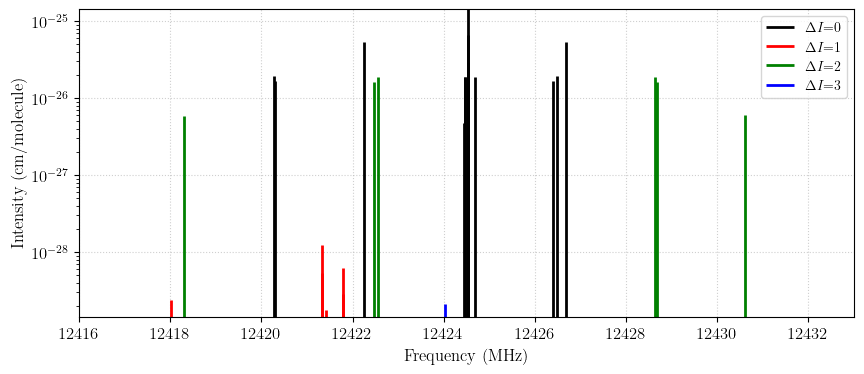

In [28]:
# frequency range (MHz)
nu1 = 12416
nu2 = 12433
freq, abscoef, spin_diff, quanta, w_para = stick_spectrum(nu1, nu2)

fig = plt.figure(figsize=(10, 4), dpi=100)

color = ("black", "red", "green", "blue")

for diff in range(4):
    ind = np.where(spin_diff == diff)[0]
    if len(ind) == 0:
        continue

    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[diff],
        linewidth=2,
        label=f"$\\Delta I$={diff}",
    )

plt.yscale("log")
plt.xlim([nu1, nu2])
plt.ylim([np.max(abscoef) * 1e-4, np.max(abscoef)])
plt.grid(True, linestyle=":", alpha=0.6)
plt.xlabel("Frequency (MHz)", fontsize=12)
plt.ylabel("Intensity (cm/molecule)", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.legend()
plt.show()

For comparision, here is an extract of Fig. 1 from [Kanamori]

<img src="../etc/data/s2cl2/Kanamori_PRL119_2017_Fig1.1.png" alt="Extract from Fig. 1 in Kanamori, et al. Phys. Rev. Lett. 119 (2017) 173401" width="900"/>

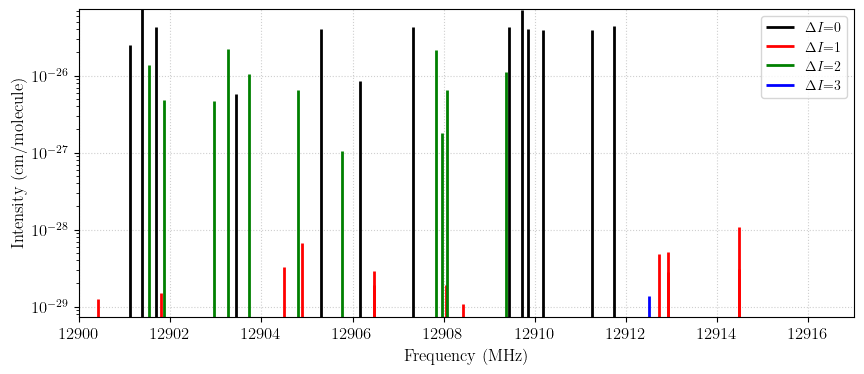

In [29]:
# frequency range (MHz)
nu1 = 12900
nu2 = 12917
freq, abscoef, spin_diff, quanta, w_para = stick_spectrum(nu1, nu2)

fig = plt.figure(figsize=(10, 4), dpi=100)

color = ("black", "red", "green", "blue")

for diff in range(4):
    ind = np.where(spin_diff == diff)[0]
    if len(ind) == 0:
        continue

    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[diff],
        linewidth=2,
        label=f"$\\Delta I$={diff}",
    )

plt.yscale("log")
plt.xlim([nu1, nu2])
plt.ylim([np.max(abscoef) * 1e-4, np.max(abscoef)])
plt.grid(True, linestyle=":", alpha=0.6)
plt.xlabel("Frequency (MHz)", fontsize=12)
plt.ylabel("Intensity (cm/molecule)", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.legend()
plt.show()

For comparision, here is an extract of Fig. 1 from [Kanamori]

<img src="../etc/data/s2cl2/Kanamori_PRL119_2017_Fig1.2.png" alt="Extract from Fig. 1 in Kanamori, et al. Phys. Rev. Lett. 119 (2017) 173401" width="900"/>

Plot full spectrum.

max acoef: 1.1791488484208452e-23


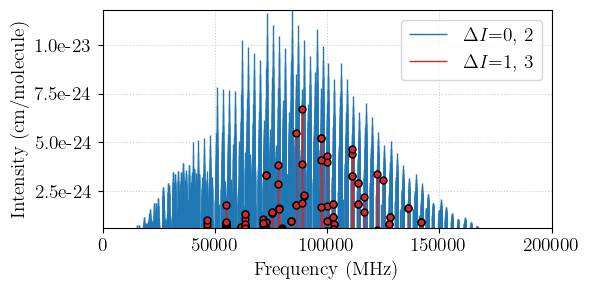

In [30]:
# frequency range (MHz)
nu1 = 0
nu2 = 200000
freq, abscoef, spin_diff, quanta, w_para = stick_spectrum(nu1, nu2)
w_para1, w_para2 = w_para.T

amax = np.max(abscoef)
print("max acoef:", amax)

fig = plt.figure(figsize=(6, 3), dpi=100)

diff_list = (0, 1, 2, 3)
color = ("tab:blue", "tab:red", "tab:blue", "tab:red")
linewidth = (1, 1, 1, 1)
marker = ("", "o", "", "o")

ind_list = [
    np.where((spin_diff == diff) & (abscoef >= amax * 1e-4))[0] for diff in diff_list
]

for i, ind in enumerate(ind_list):
    if len(ind) == 0:
        continue
    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[i],
        linewidth=linewidth[i],
        label=(
            f"$\\Delta I$={diff_list[i]}, {diff_list[i]+2}"
            if diff_list[i] in (0, 1)
            else ""
        ),
    )

ind_mixed = np.where(
    ((w_para1 > 0.4) & (w_para1 < 0.6))
    | ((w_para2 > 0.4) & (w_para2 < 0.6)) & (abscoef >= amax * 1e-4)[0]
)
plt.vlines(
    freq[ind_mixed], ymin=0, ymax=abscoef[ind_mixed], color="tab:red", linewidth=1
)

for i, ind in enumerate(ind_list):
    if len(ind) == 0:
        continue
    if marker[diff_list[i]]:
        plt.plot(
            freq[ind],
            abscoef[ind],
            linestyle="None",
            color=color[i],
            mec="black",
            marker=marker[i],
            markersize=5,
        )

plt.xlim([nu1, nu2])
plt.ylim([amax * 5e-2, amax])
plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=14)

plt.xlabel("Frequency (cm$^{-1}$)", fontsize=14)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Frequency (MHz)", fontsize=14)
plt.ylabel("Intensity (cm/molecule)", fontsize=14)
plt.legend(fontsize=14, loc="upper right")

formatter = FuncFormatter(lambda x, _: f"{x:.1e}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()

plt.savefig(f"s2cl2_35_35_op_spectrum.pdf", format="pdf", bbox_inches="tight")